In [197]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats
import scipy.interpolate as interpolate
# setting parameters for default matplotlib plots
%matplotlib inline

In [198]:
pl.style.use('fabiostyle')
# pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
# pl.rcParams['xtick.labelsize'] = 7
# pl.rcParams['ytick.labelsize'] = 7
# pl.rcParams['axes.labelsize'] = 7
# pl.rcParams['axes.titlesize'] = 7

# needs to find the library of functions
sys.path.append('../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [199]:
NOTEBOOK_NAME = 'breathing'

In [200]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [201]:
for var in 'events', 'time_ax', 'STIM1_ons','STIM2_ons','STIM3_ons','STIM4_ons','cycles','CYCLE_START', 'CYCLE_DURATION':
    exec("%s = ut.load_variable('%s', '../notebooks/autorestore/preprocessing')"%(var, var))
# events = ut.load_variable('traces', '../calvin/sepodor_pre/notebooks/autorestore/preprocessing')
# time_ax = ut.load_variable('time_ax', '../calvin/sepodor_pre/notebooks/autorestore/preprocessing')
# behavior = ut.load_variable('behavior', '../calvin/sepodor_pre/notebooks/autorestore/preprocessing')
# odor_ons = ut.load_variable('odor1_ons', '../calvin/sepodor_pre/notebooks/autorestore/preprocessing')

In [202]:
import pandas as pd

In [203]:
from scipy import signal

In [204]:
def peakdet(v, delta=0.02, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        raise Exception('Input vectors v and x must have same length')
    
    if not np.isscalar(delta):
        raise Exception('Input argument delta must be a scalar')
    
    if delta <= 0:
        raise Exception('Input argument delta must be positive')
    
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    
    lookformax = True
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

In [205]:
def read_respiration_times(filename, **args):
    """
    Reads respiration times from a csv file (see breathing.ipynb).
    It uses peak detection to determine respiration times.
    Arguments: csv filename, arguments for peakdet.
    Returns: time, voltage value, respiration events, respiration rate.
    See also: peakdet function.
    """
    voltage = pd.read_csv(filename, index_col=0)
    voltage.index = voltage.index*1e-3
    voltage.index.name = 'Time (s)'
    a,b = peakdet(voltage.values, **args)
    
    respiration = np.zeros(len(voltage))
    idxs = np.array(a[:, 0].astype(int))
    respiration[idxs]=1
    
    resp_rate_ = 1./np.diff(voltage.index.values[respiration>0])
    
    respiration = np.zeros(len(voltage))
    idxs = np.array(a[:, 0].astype(int))
    respiration[idxs[1:]]=1
    
    return (voltage.index.values, voltage.values.flatten(),
            respiration, resp_rate_, a,b)



In [206]:

time_ax_val=[]
voltage = []
respiration = []
resp_rate_ = []
a=[]
b=[]
id_range = ['00001','00002','00003','00004','00005','00006','00007','00008','00009','00010',
            '00011','00012','00013','00014','00015','00016','00017','00018','00019','00020',
            '00021','00022','00023','00024','00025','00026','00027','00028','00029','00030',
            '00031','00032','00033','00034','00035','00036','00037','00038','00039','00040',
            '00041','00042','00043','00044','00045','00046','00047','00048','00049','00050',
            '00051','00052','00053','00054','00055','00056','00057','00058','00059','00060',
            '00061','00062','00063','00064','00065','00066','00067','00068','00069','00070',
            '00071','00072','00073','00074','00075','00076','00077','00078','00079','00080',
            '00081','00082','00083','00084','00085','00086','00087','00088','00089','00090',
            '00091','00092','00093','00094','00095','00096','00097','00098','00099','00100',
            '00101','00102','00103','00104','00105','00106','00107','00108','00109','00110',
            '00111','00112','00113','00114','00115','00116','00117','00118','00119','00120',]

data_folder = '../data'

c ='Cycle'
d= '_VoltageRecording_001.csv'

for i in id_range:
    for file in os.listdir(data_folder):
        ending = c+i+d
        if file.endswith(ending):
            csvfile = data_folder + '/' + file
    
    exec("time_ax_val_t, voltage_t, respiration_t, resp_rate__t,a_t,b_t = read_respiration_times('%s')"%(csvfile))
    time_ax_val.append(time_ax_val_t)
    voltage.append(voltage_t)
    #breaths = [respiration_t>0][1:]
    #respiration_t = respiration_t[breaths]
    respiration.append(respiration_t)
    resp_rate_.append(resp_rate__t)
    a.append(a_t)
    b.append(b_t)


resp_rate_ = [item for sublist in resp_rate_ for item in sublist]
respiration = [item for sublist in respiration for item in sublist]
voltage = [item for sublist in voltage for item in sublist]

time_ax_val_n = []
for i in range(len(time_ax_val)*len(time_ax_val[0])):
    time_ax_val_n.append(i*1.38*time_ax_val[0][1])

In [240]:
time_ax_val_t[0:20]

array([ 0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,  0.003 ,
        0.0035,  0.004 ,  0.0045,  0.005 ,  0.0055,  0.006 ,  0.0065,
        0.007 ,  0.0075,  0.008 ,  0.0085,  0.009 ,  0.0095])

In [207]:
def plot_breathing_heatmap(breathing_around_onset, onset, colorbar_label=None, cmap=None,
                           vmax=None, vmin=None, colorbar=True, xlabel=True, ylabel=True, vline_color='r', ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1)
    if cmap is None:
        cmap = pl.cm.viridis
    
    im = ax.imshow(breathing_around_onset, aspect='auto', extent=(-3, 5, 0, len(onset)), origin='lower',
                   vmax=vmax, vmin=vmin, cmap=cmap)
    ax.vlines(0, 0, len(onset), color=vline_color)
    if xlabel:
        ax.set_xlabel("Time from Odor Onset (s)")
    if colorbar:
        cax = ax.figure.add_axes((1, 0.2, 0.02, 0.6))
        pl.colorbar(im, cax=cax)
    #     cax.set_ylabel('mV')
        if colorbar_label is not None:
            cax.set_ylabel(colorbar_label)

    if ylabel:
        ax.set_ylabel('Trial #')
    
    return ax

In [223]:
len(time_ax_val_n)

4080000

In [224]:
len(time_ax)

7740

In [227]:
len(resp_rate_)

6160

In [208]:
np.array(time_ax_val_n)[np.array(respiration)>0]

array([  8.48700000e-01,   2.35911000e+00,   2.65305000e+00, ...,
         2.81425401e+03,   2.81469147e+03,   2.81492469e+03])

In [209]:
time_ax

array([  0.00000000e+00,   2.64532768e-01,   5.29065536e-01, ...,
         2.81422628e+03,   2.81449088e+03,   2.81475548e+03])

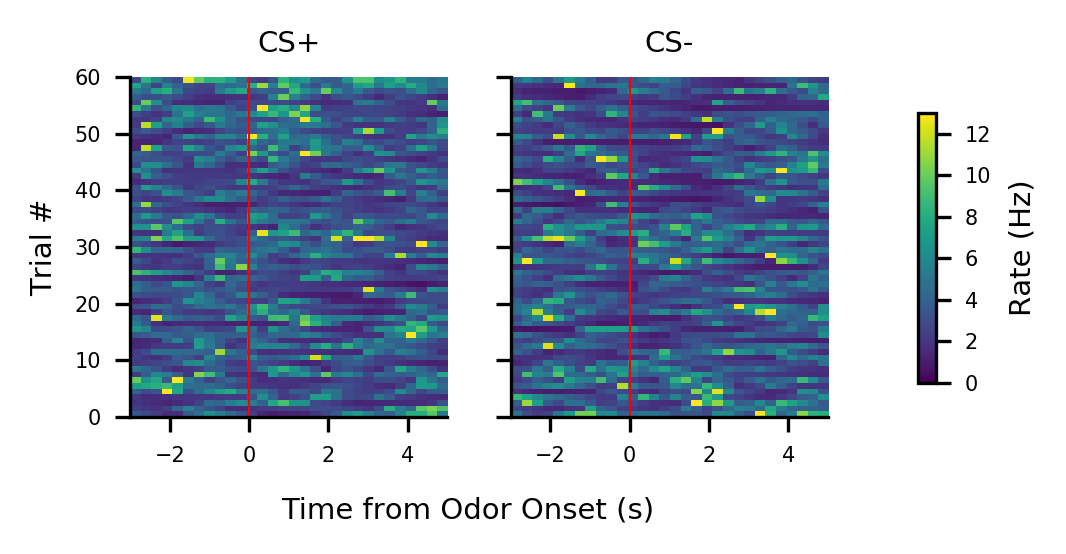

In [210]:
resp_rate = np.interp(time_ax, np.array(time_ax_val_n)[np.array(respiration)>0], np.array(resp_rate_))

rate_around_onset_csp=[]
rate_around_onset_csm=[]

csp_ons = np.sort(np.r_[STIM1_ons, STIM2_ons])
csm_ons = np.sort(np.r_[STIM3_ons, STIM4_ons])

rate_around_onset_csp.append(ut.extract_traces_around_event(time_ax, resp_rate, csp_ons, 3, 5))

rate_around_onset_csm.append(ut.extract_traces_around_event(time_ax, resp_rate, csm_ons, 3, 5))

fig, axs = pl.subplots(1, 2, figsize=(3, 1.5), sharey=True)
plot_breathing_heatmap(rate_around_onset_csp[0], csp_ons, colorbar_label='Rate (Hz)', vmax=13, vmin=0,
                            colorbar=True, xlabel=False, ax=axs[0])
plot_breathing_heatmap(rate_around_onset_csm[0], csm_ons, colorbar_label='Rate (Hz)', vmax=13, vmin=0,
                            colorbar=False, xlabel=False, ylabel=False, ax=axs[1])

axs[0].set_title('CS+')
axs[1].set_title('CS-')

fig.text(0.5, -0.1, "Time from Odor Onset (s)", ha='center', fontsize=7)

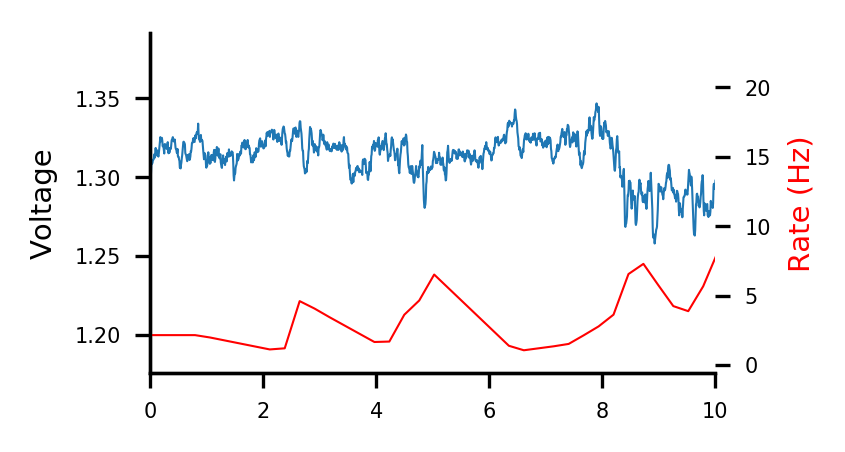

In [211]:
pl.plot(time_ax_val_n[::10], voltage[::10], '-', mew=0, ms=2)
pl.ylabel('Voltage')

pl.twinx()
pl.plot(time_ax, resp_rate, 'r-')
# pl.ylabel("Rate", color='r')

pl.xlim(0, 10)

pl.xlabel('Time (s)')
pl.ylabel('Rate (Hz)', color='r')

In [212]:
csm_ons = np.sort(np.r_[STIM3_ons, STIM4_ons])
csp_ons = np.sort(np.r_[STIM1_ons, STIM2_ons])
rate_around_onset_csp = ut.extract_traces_around_event(time_ax, resp_rate, csp_ons, 3, 5)
evs_around_onset_csp = ut.extract_traces_around_event(time_ax, events, csp_ons, 3, 5)

In [213]:
rate_around_onset_csm = ut.extract_traces_around_event(time_ax, resp_rate, csm_ons, 3, 5)
evs_around_onset_csm = ut.extract_traces_around_event(time_ax, events, csm_ons, 3, 5)

In [214]:
csp_ons

array([    5.97532841,   121.70347539,   168.01355341,   192.68201075,
         235.29373206,   307.70828598,   332.15274561,   377.84479097,
         398.38074274,   490.49977348,   613.30684717,   635.2677913 ,
         710.52653327,   733.46982058,   755.50193408,   802.30095884,
         825.40151989,   848.36098196,   938.92001286,  1007.27495753,
        1027.52907141,  1051.24498318,  1075.70405768,  1217.68409779,
        1243.54299827,  1269.1800734 ,  1294.72998372,  1317.14009363,
        1338.10904319,  1362.96912363,  1454.23116447,  1475.48910467,
        1495.65086261,  1538.21624343,  1581.20925644,  1606.80613904,
        1734.52252498,  1757.97210521,  1784.33118326,  1835.02319302,
        1902.62818305,  1948.11920561,  1971.45429348,  2090.01623452,
        2132.48727817,  2152.6483869 ,  2174.55831055,  2197.00339178,
        2266.98095271,  2362.60444186,  2388.06034859,  2410.82844658,
        2480.11339084,  2504.16447402,  2530.50752821,  2556.94642927,
      

In [215]:
def plot_breathing_heatmap(breathing_around_onset, onset, colorbar_label=None, cmap=None,
                           vmax=None, vmin=None, colorbar=True, xlabel=True, ylabel=True, vline_color='r', ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1)
    if cmap is None:
        cmap = pl.cm.viridis
    
    im = ax.imshow(breathing_around_onset, aspect='auto', extent=(-3, 5, 0, len(onset)), origin='lower',
                   vmax=vmax, vmin=vmin, cmap=cmap)
    ax.vlines(0, 0, len(onset), color=vline_color)
    if xlabel:
        ax.set_xlabel("Time from Odor Onset (s)")
    if colorbar:
        cax = ax.figure.add_axes((1, 0.2, 0.02, 0.6))
        pl.colorbar(im, cax=cax)
    #     cax.set_ylabel('mV')
        if colorbar_label is not None:
            cax.set_ylabel(colorbar_label)

    if ylabel:
        ax.set_ylabel('Trial #')
    
    return ax

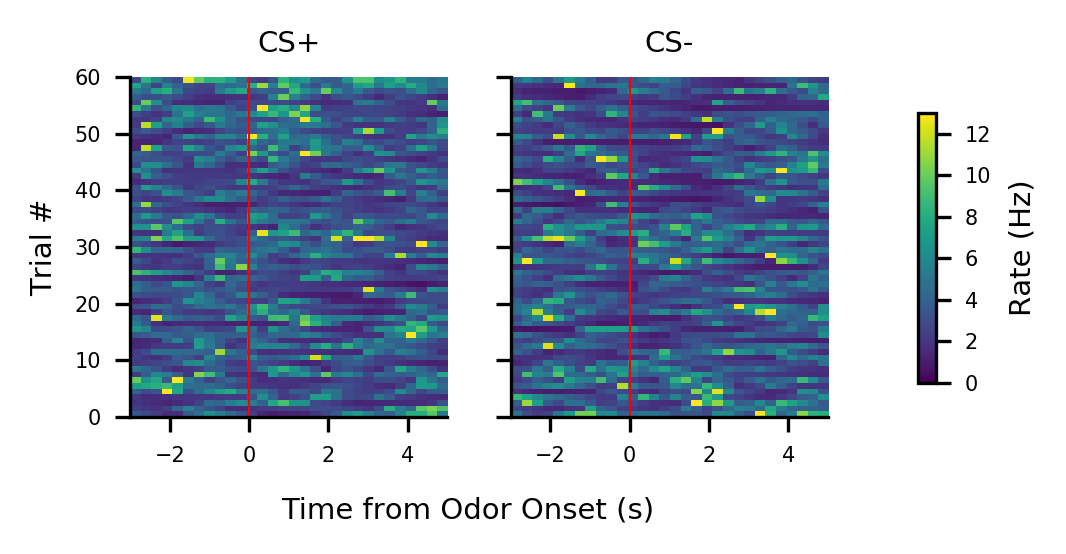

In [216]:
fig, axs = pl.subplots(1, 2, figsize=(3, 1.5), sharey=True)
plot_breathing_heatmap(rate_around_onset_csp, csp_ons, colorbar_label='Rate (Hz)', vmax=13, vmin=0,
                            colorbar=True, xlabel=False, ax=axs[0])
plot_breathing_heatmap(rate_around_onset_csm, csm_ons, colorbar_label='Rate (Hz)', vmax=13, vmin=0,
                            colorbar=False, xlabel=False, ylabel=False, ax=axs[1])

axs[0].set_title('CS+')
axs[1].set_title('CS-')

fig.text(0.5, -0.1, "Time from Odor Onset (s)", ha='center', fontsize=7)


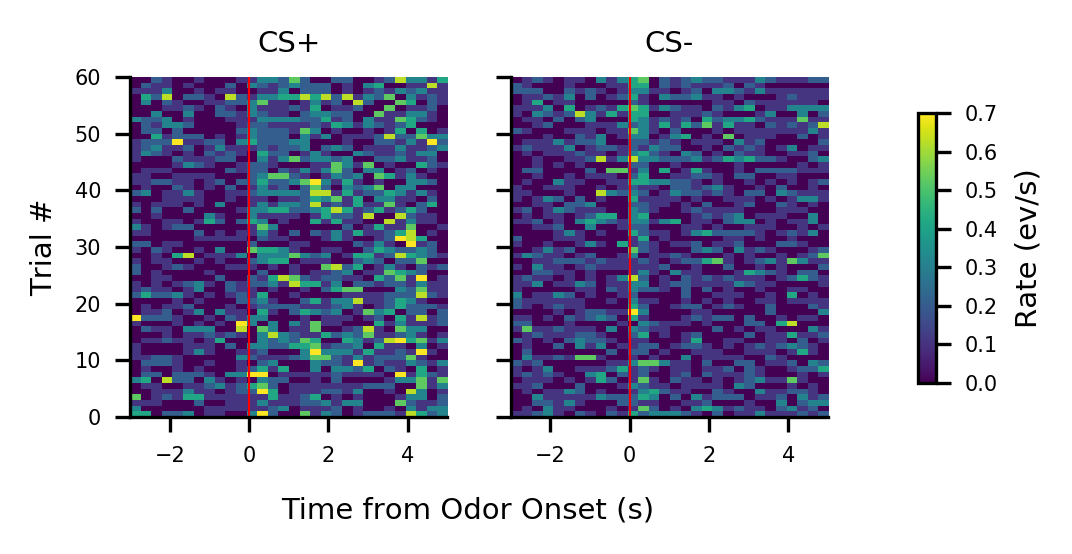

In [217]:
fig, axs = pl.subplots(1, 2, figsize=(3, 1.5), sharey=True)
plot_breathing_heatmap((evs_around_onset_csp>0).mean(2)/np.diff(time_ax)[0], csp_ons, colorbar_label='Rate (ev/s)',
                       vmin=0, vmax=0.7, colorbar=True, xlabel=False, ax=axs[0])
plot_breathing_heatmap((evs_around_onset_csm>0).mean(2)/np.diff(time_ax)[0], csm_ons, colorbar_label='Rate (ev/s)',
                       vmin=0, vmax=0.7, colorbar=False, xlabel=False, ylabel=False, ax=axs[1])

axs[0].set_title('CS+')
axs[1].set_title('CS-')

fig.text(0.5, -0.1, "Time from Odor Onset (s)", ha='center', fontsize=7)

# save pdf

In [218]:
save_workspace(db)

Could not store variable 'interpolate'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pd'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'f'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'signal'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
